# Scraping Script

Processing the scraped data is further below

In [1]:
import asyncio
import nest_asyncio
import csv
import datetime
from dotenv import load_dotenv
import os

from telethon import TelegramClient, events, sync
from telethon.tl.functions.messages import GetHistoryRequest
import pandas as pd

import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# for the data labelling, comment out if not used
from tqdm.notebook import tqdm
import ollama

from pydantic import BaseModel, Field, ValidationError
from typing import Dict, List, Literal

In [2]:
load_dotenv()
api_id = os.getenv("TELE_API") 
api_hash = os.getenv("TELE_HASH")
session_name = 'tele_scrape_btc'

nest_asyncio.apply()

For reference, these are the channel names, handles and IDs

IDs may differ between users so the handles are provided here for reproducibility

* Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
* Channel Name: Binance Killers®, Tele Handle: binancekillers
* Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
* Channel Name: Fed. Russian Insiders®, Tele Handle: FedRussianInsiders
* Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
* Channel Name: Whales Crypto Guide, Tele Handle: Whalesguide

In [3]:
chat_names = ["Crypto Pump Club", "Binance Killers", "Wallstreet Queen Official", "Technical CRYPTO Analyst", "Whales Crypto Guide", "Fed. Russian Insiders"]

In [4]:
chats = {}
async def find_channel(channel_names):
    """ Function to find the correct ID of channel or group chats

    Args:
        channel_names (list(str)): list of strings of partial channel names to search for
    
    Outputs:
        prints matched channels with their IDs
    """
    
    async with TelegramClient(session_name, api_id, api_hash) as client:
        
        dialogs = await client.get_dialogs()
        channels = [dialog for dialog in dialogs if dialog.is_channel]

        for channel in channels:
            if any(channel_name.lower() in channel.name.lower() for channel_name in channel_names):
                print(f"{channel.name} found with id: {channel.entity.id}, username: {channel.entity.username}")
                chats[channel.name] = [channel.entity.id, channel.entity.username]

asyncio.run(find_channel(chat_names))


Fed. Russian Insiders® found with id: 1317169843, username: FedRussianInsiders
Binance Killers® found with id: 1220789766, username: binancekillers
Crypto Pump Club 📈 found with id: 1625691880, username: cryptoclubpump
Technical CRYPTO Analyst found with id: 1349397698, username: TechCryptoAnalyst
Wallstreet Queen Official® found with id: 1347728413, username: wallstreetqueenofficial
Whales Crypto Guide found with id: 1288385100, username: Whalesguide
Whales Crypto Guide found with id: 1047983700, username: WhalesCryptosGuider
Fed. Russian Insiders® found with id: 1437767832, username: king32213


In [5]:
for name, data in chats.items():
    print(f"Channel Name: {name}, Tele Handle: {data[1]}")
    print(f"ID: {data[0]}", end="\n\n")

Channel Name: Fed. Russian Insiders®, Tele Handle: king32213
ID: 1437767832

Channel Name: Binance Killers®, Tele Handle: binancekillers
ID: 1220789766

Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
ID: 1625691880

Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
ID: 1349397698

Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
ID: 1347728413

Channel Name: Whales Crypto Guide, Tele Handle: WhalesCryptosGuider
ID: 1047983700



In [6]:
async def fetch_messages():
    df = pd.DataFrame(columns=["channel", "text", "date"])
    earliest_msg = datetime.datetime(2024, 1, 1) # March 1st as temporary testing
    async with TelegramClient(session_name, api_id, api_hash) as client:
        await client.start()
        for _, (channel_id, channel_handle) in chats.items():
            
            channel = await client.get_entity(channel_id)
            print(channel.title)
            messages = []
            async for message in client.iter_messages(channel, reverse=True, offset_date=earliest_msg, limit=None): # adjust limit as necessary
                messages.append({
                    "channel": channel_handle,
                    #"sender": int(message.sender_id),
                    "text": message.text,
                    "date": message.date
                }) 
            df = pd.concat([df, pd.DataFrame(messages)], ignore_index=True)
        df.to_csv("../data/raw/tele_channel_messages.csv", encoding="utf-8-sig", index=False)

asyncio.run(fetch_messages())

Fed. Russian Insiders®
Binance Killers®
Crypto Pump Club 📈
Technical CRYPTO Analyst
Wallstreet Queen Official®
Whales Crypto Guide


# Cleaning up data

In [7]:
df = pd.read_csv(r"../data/raw/tele_channel_messages.csv")

In [8]:
print(df.isna().sum())
df = df.dropna()
print(df.info())

channel      0
text       335
date         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 12240 entries, 0 to 12574
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  12240 non-null  object
 1   text     12240 non-null  object
 2   date     12240 non-null  object
dtypes: object(3)
memory usage: 382.5+ KB
None


In [10]:
df

,channel,text,date
0,binancekillers,**✔️****✔️****GMX****✔️****✔️**,2024-01-01 01:15:20+00:00
1,binancekillers,📍SIGNAL ID: #1311📍\n**COIN: ****$GMX****/USDT ...,2024-01-01 01:16:01+00:00
2,binancekillers,BK® Crypto Fear and Greed Index\n➖➖➖➖➖➖➖\n- Bi...,2024-01-01 03:28:01+00:00
3,binancekillers,📍TRADING TIP OF THE DAY #819📍,2024-01-01 05:18:01+00:00
4,binancekillers,"**January 1, 2024\n➖➖➖➖➖➖➖\nMARKET ANALYSIS:**...",2024-01-01 06:58:01+00:00
...,...,...,...
12570,WhalesCryptosGuider,🚀🚀🔥🔥🔥,2024-09-25 06:22:05+00:00
12571,WhalesCryptosGuider,**Buying** #FET Here\n\nCan **Long(3x-5x)**\n\...,2024-09-26 11:32:05+00:00
12572,WhalesCryptosGuider,Bitcoin's hash rate has surged to an unprecede...,2024-10-23 03:14:37+00:00
12573,WhalesCryptosGuider,Bitcoin's hash rate has surged to an unprecede...,2024-11-02 03:50:52+00:00


In [9]:
df = df.drop(columns=["sender"], axis=0)
df.head()

KeyError: "['sender'] not found in axis"

In [13]:
df = df.dropna(subset=['channel']).reset_index(drop=True)
encoder = OneHotEncoder(sparse_output=False,drop=None)#sparse=False, 
encoded_senders = encoder.fit_transform(df[['channel']])
encoded_df = pd.DataFrame(encoded_senders, columns=encoder.get_feature_names_out(['channel']), index=df.index)
df = df.drop(columns=['channel']) 
df = pd.concat([df, encoded_df], axis=1) 

In [14]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII characters (emojis)
    return text

df["text"] = df["text"].apply(clean_text)

In [17]:
df.sort_values(by='date', inplace=True)
df

,text,date,channel_TechCryptoAnalyst,channel_WhalesCryptosGuider,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial
0,**********GMX**********,2024-01-01 01:15:20+00:00,0.0,0.0,1.0,0.0,0.0
1,SIGNAL ID: #1311 **COIN: ****$GMX****/USDT (3-...,2024-01-01 01:16:01+00:00,0.0,0.0,1.0,0.0,0.0
2,BK Crypto Fear and Greed Index - Binance Killers,2024-01-01 03:28:01+00:00,0.0,0.0,1.0,0.0,0.0
9957,**COIN NAME: ****#DEFI****/USDT** LONG SET-UP ...,2024-01-01 05:16:43+00:00,0.0,0.0,0.0,0.0,1.0
3,TRADING TIP OF THE DAY #819,2024-01-01 05:18:01+00:00,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
6402,**VIP UPDATE** SEC acknowledges filing for F...,2025-04-03 18:14:50+00:00,0.0,0.0,1.0,0.0,0.0
6403,"President Trump: ""Get ready, the market is ab...",2025-04-03 18:43:12+00:00,0.0,0.0,1.0,0.0,0.0
6404,VIP MARKET UPDATE: **$BTC** BTC is currently ...,2025-04-03 21:07:39+00:00,0.0,0.0,1.0,0.0,0.0
6405,VIP Crypto Market RSI Heatmap Timeframe: Daily...,2025-04-03 23:02:01+00:00,0.0,0.0,1.0,0.0,0.0


In [18]:
# keywords, if we can have a moderately fast method to assess reliably if news affects btc or bitcoin like crypto outlook, will be even better
keywords = ['bitcoin', 'btc']
df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2143 entries, 4 to 6404
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   text                             2143 non-null   object 
 1   date                             2143 non-null   object 
 2   channel_TechCryptoAnalyst        2143 non-null   float64
 3   channel_WhalesCryptosGuider      2143 non-null   float64
 4   channel_binancekillers           2143 non-null   float64
 5   channel_cryptoclubpump           2143 non-null   float64
 6   channel_wallstreetqueenofficial  2143 non-null   float64
dtypes: float64(5), object(2)
memory usage: 133.9+ KB


In [20]:
# remove duplicates
orig_size = df.shape[0]
df = df.drop_duplicates(subset=["text"])

print(f"Dataset size after removing duplicates from {orig_size} to {df.shape[0]}")

Dataset size after removing duplicates from 2143 to 2078


In [21]:
# remove short sentences
orig_size = df.shape[0]
df['words'] = [len(x.split()) for x in df['text'].tolist()]
df = df[df["words"] > 5 ]
df = df[df["words"] < 256]
df = df.drop(columns=["words"])

print(f"Dataset size after filtering from {orig_size} to {df.shape[0]}")

Dataset size after filtering from 2078 to 2036


In [22]:
df.to_csv(r"../data/processed/tele_messages_processed.csv")

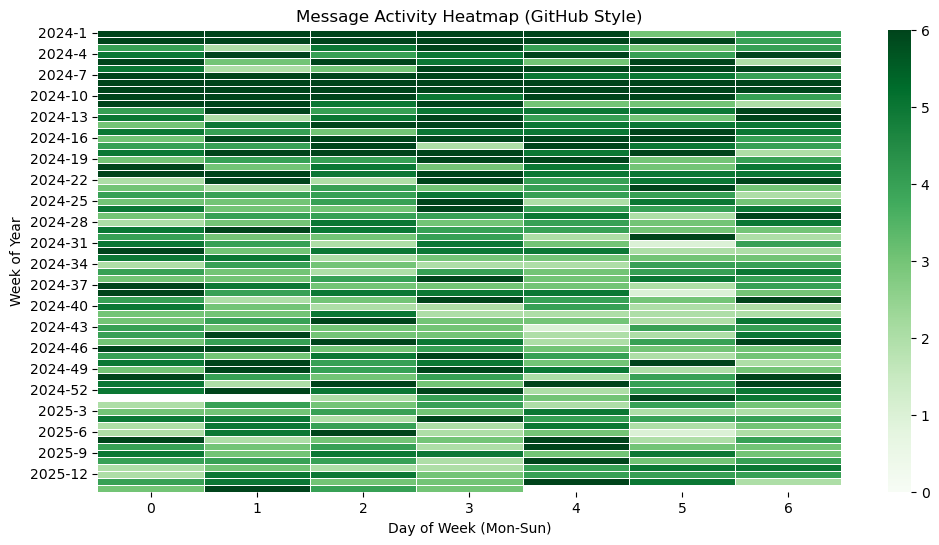

In [23]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

heatmap_data = df.groupby(['year', 'week', 'day']).size().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=6)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Message Activity Heatmap (GitHub Style)")

plt.show()

# Sentiment Ollama

just take note here that first 2 days of 2025 has no news

In [2]:
df = pd.read_csv(r"../data/processed/tele_messages_processed.csv")
class Sentiment(BaseModel):
    """ Sentiment of Bitcoin outlook from the financial news"""
    sentiment: Literal["positive", "negative", "neutral"]

    @classmethod
    def from_response(cls, response: str):
        """Parse and validate response from Ollama"""
        try:
            normalized_response = response.strip().lower()  
            if normalized_response not in {"positive", "negative", "neutral"}:
                raise ValueError(f"Unexpected sentiment: {normalized_response}")
            return cls(sentiment=normalized_response)
        except (ValidationError, ValueError) as e:
            print(f"Error parsing response: {e}; Response: {response}")
            return cls(sentiment="neutral")  # fallback to neutral

In [5]:
model_name = "llama3:8b"
def get_sentiment(text):
    prompt = f"""Analyze the sentiment of the following crypto financial text to determine if the outlook on Bitcoin or BTC is positive.
    Text: "{text}"
    
    Provide a single-word label: Positive, Negative, or Neutral.
    Only return the label without additional text.

    Take note that a positive outlook on the crypto market also means that it will result in a positive outlook on Bitcoin and vice versa.
    For example:
    Text:
    Pump into Crypto, market looks good!

    Sentiment: Positive
    """
    
    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    
    return Sentiment.from_response(response["message"]["content"])

In [6]:
tqdm.pandas()
df["sentiment"] = df["text"].progress_apply(get_sentiment)
df["sentiment"] = df["sentiment"].apply(lambda x: x.sentiment if isinstance(x, Sentiment) else x)

  0%|          | 0/2036 [00:00<?, ?it/s]

In [10]:
counts = df["sentiment"].value_counts()
print(counts)
df.to_csv(r"../data/processed/tele_messages_processed_hourly_4thApr.csv")

sentiment
positive    1513
neutral      351
negative     172
Name: count, dtype: int64


In [8]:
# Viewing sentiments randomly, 10 of each
sampled_texts = df.groupby("sentiment")["text"].apply(lambda x: x.sample(n=10, random_state=42, replace=True)).reset_index()

output_text = ""
for sentiment in ["positive", "negative", "neutral"]:
    output_text += f"\n=== {sentiment.upper()} ===\n"
    if sentiment in sampled_texts["sentiment"].values:
        texts = sampled_texts[sampled_texts["sentiment"] == sentiment]["text"].tolist()
        output_text += "\n".join(f"- {t}" for t in texts)
    else:
        output_text += "No examples found.\n"

print(output_text)


=== POSITIVE ===
- VIP MARKET UPDATE: $BTC   BTC hit $98K   - Binance Killers
- **FLASH VIP SALE******** Final Chance!!**  **DONT MISS THE BULL RUN, JOIN OUR VIP TODAY** BTC is getting ready for its next big move, and the alt season is around the corner Were about to see the most profitable moves of the year, once in a lifetime trades and as always were catching them all.**** Dont miss this Bull Market Limited Spots Available!!  -> 1 Month - $290 -> 3 Months - $480 **->****Lifetime - $600 (was $2,700)** **USDT (TRC20)**: `TRsSApP1GwCaxnqQCMN5yeqeGG1t36CEJH` **BTC**:** **`12LyvUGAqbkrNhuZMJKcFiEFRX8jQewHDs` **SOL:** `59EPy8juo7crJUbB2VoTxj6CgEkohzoVRVmtfXqnaqhJ` __(tap payment address to copy)__ *__To complete your registration send a transaction confirmation screenshot to ____t.me/@BKCEO____ __ **What does Binance Killers VIP include?** 92%+ Accuracy Futures/Spot/Alt Signals: Scalps (1-2 per day on average), Swing Trades (2-3 per week) and our obscene Mega Signals (1 every 1-2 months)

In [11]:
df = pd.read_csv(r"../data/processed/tele_messages_processed_hourly_4thApr.csv")

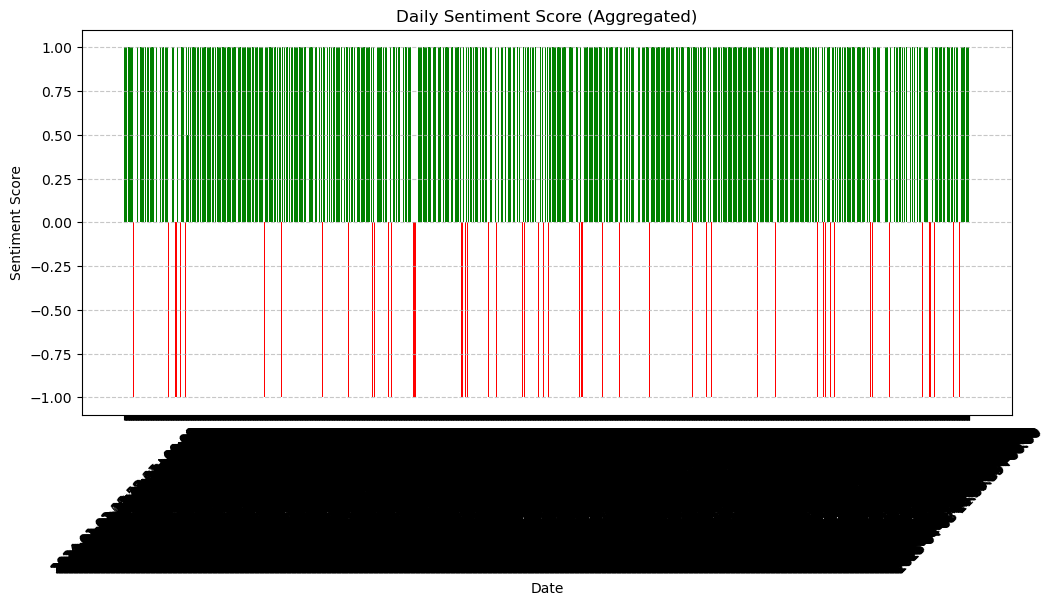

In [12]:

# df["date"] = pd.to_datetime(df["date"]).dt.date  # Keep only the date part

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

# Aggregate sentiment scores per day
daily_sentiment = df.groupby("date")["sentiment_score"].mean()

# Plot sentiment over time (GitHub-style heatmap)
plt.figure(figsize=(12, 5))
plt.bar(daily_sentiment.index, daily_sentiment.values, color=np.where(daily_sentiment > 0, 'green', 'red'))

plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Daily Sentiment Score (Aggregated)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



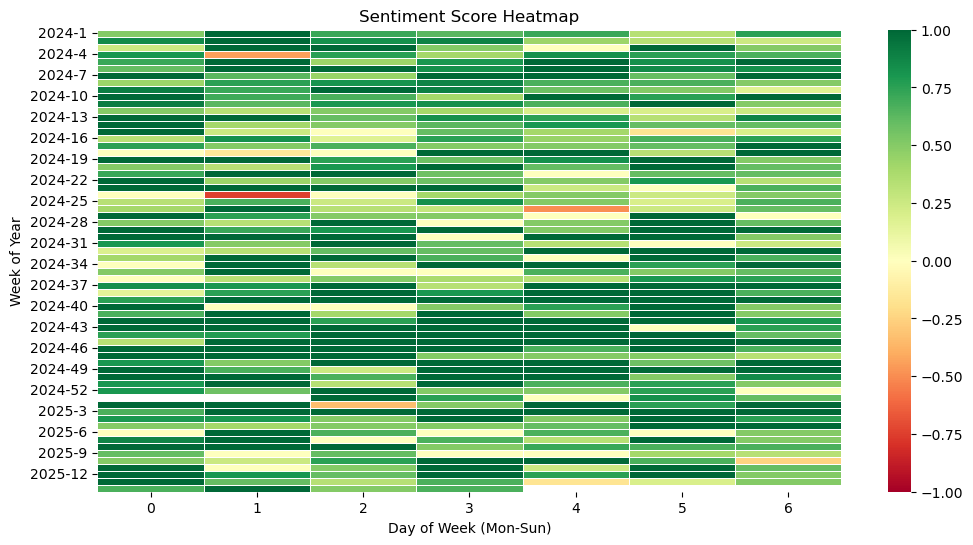

In [13]:
df["date"] = pd.to_datetime(df["date"])

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week
df["day"] = df["date"].dt.dayofweek  

heatmap_data = df.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()


# Creating Decaying scores

Linear and Weibull distribution
Based on ethans code in "reddit_preprocess.ipynb"

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
folder_path = '../data/processed/'

In [16]:
tele_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             2036 non-null   int64  
 1   Unnamed: 0                       2036 non-null   int64  
 2   text                             2036 non-null   object 
 3   date                             2036 non-null   object 
 4   channel_TechCryptoAnalyst        2036 non-null   float64
 5   channel_WhalesCryptosGuider      2036 non-null   float64
 6   channel_binancekillers           2036 non-null   float64
 7   channel_cryptoclubpump           2036 non-null   float64
 8   channel_wallstreetqueenofficial  2036 non-null   float64
 9   sentiment                        2036 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 159.2+ KB


In [17]:
tele_messages_path = os.path.join(folder_path, 'tele_messages_processed_hourly_4thApr.csv')
tele_messages = pd.read_csv(tele_messages_path).reset_index() #, index_col=0
# tele_messages = tele_messages.rename(columns = {'index': 'date'})

# Convert DATE column to datetime format
tele_messages['date'] = pd.to_datetime(tele_messages['date'])
tele_messages = tele_messages.sort_values(by='date').reset_index(drop = True)

df = tele_messages.copy()

In [19]:
# df.drop(columns=['smoothed_sentiment', 'smoothed_sentiment_weibull'], inplace=True)
df.drop(columns=['index', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [20]:
df

,text,date,channel_TechCryptoAnalyst,channel_WhalesCryptosGuider,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,sentiment
0,"**January 1, 2024 MARKET ANALYSIS:** Market C...",2024-01-01 06:58:01+00:00,0.0,0.0,1.0,0.0,0.0,positive
1,"**January 2, 2024 MARKET ANALYSIS: **Market C...",2024-01-02 10:52:37+00:00,0.0,0.0,1.0,0.0,0.0,positive
2,As $BTC recorded a new ATH of $45300. A Smart ...,2024-01-02 12:18:44+00:00,1.0,0.0,0.0,0.0,0.0,positive
3,#Bitcoin prices on New Years Eve 2013 - $754 2...,2024-01-02 14:37:44+00:00,1.0,0.0,0.0,0.0,0.0,positive
4,"#Bitcoin price : 1st Jan, 2023: $16,487 1st Ja...",2024-01-02 14:38:02+00:00,1.0,0.0,0.0,0.0,0.0,positive
...,...,...,...,...,...,...,...,...
2031,**ULTIMATE VIP SALE****** **DONT MISS THE BUL...,2025-04-02 14:26:34+00:00,0.0,0.0,1.0,0.0,0.0,positive
2032,**#Market**** Sentiment****** Bitcoin Fear and...,2025-04-02 16:25:15+00:00,0.0,0.0,0.0,0.0,1.0,neutral
2033,"**April 03, 2025 MARKET ANALYSIS:** Market Ca...",2025-04-03 07:59:38+00:00,0.0,0.0,1.0,0.0,0.0,positive
2034,"**VIP UPDATE** Michael Saylor says ""there are...",2025-04-03 14:09:59+00:00,0.0,0.0,1.0,0.0,0.0,positive


In [21]:
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

In [22]:
df = df.rename(columns={'date': 'created_at'})

In [24]:
df['created_at'] = pd.to_datetime(df['created_at'])
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

                           smoothed_sentiment
2024-01-01 06:00:00+00:00            0.000000
2024-01-01 07:00:00+00:00            0.998623
2024-01-01 08:00:00+00:00            0.956956
2024-01-01 09:00:00+00:00            0.915289
2024-01-01 10:00:00+00:00            0.873623


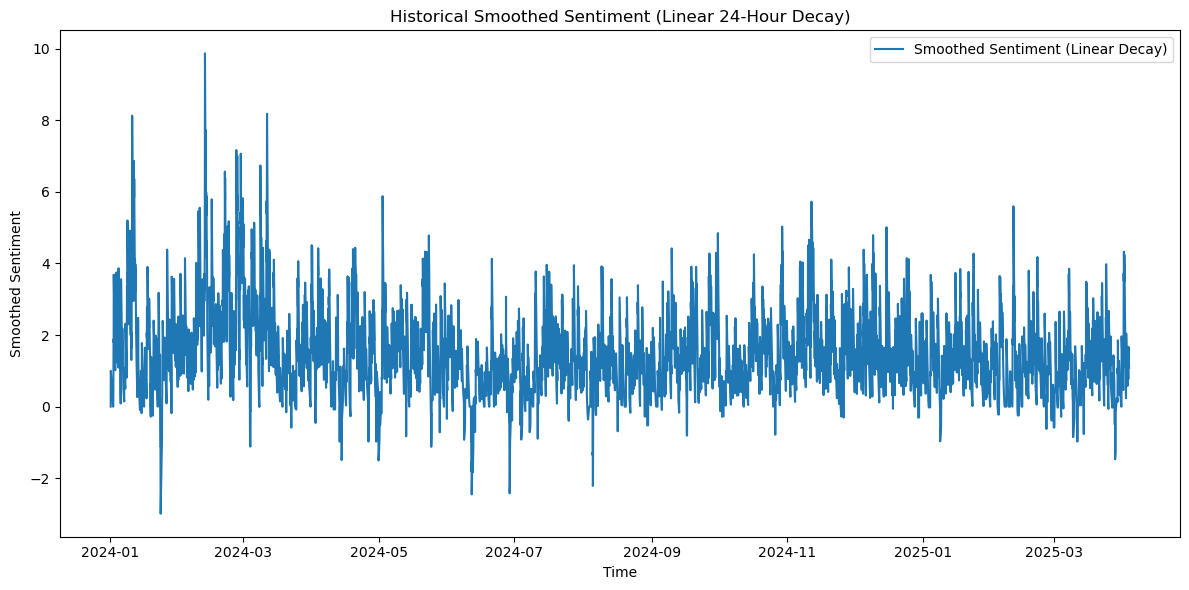

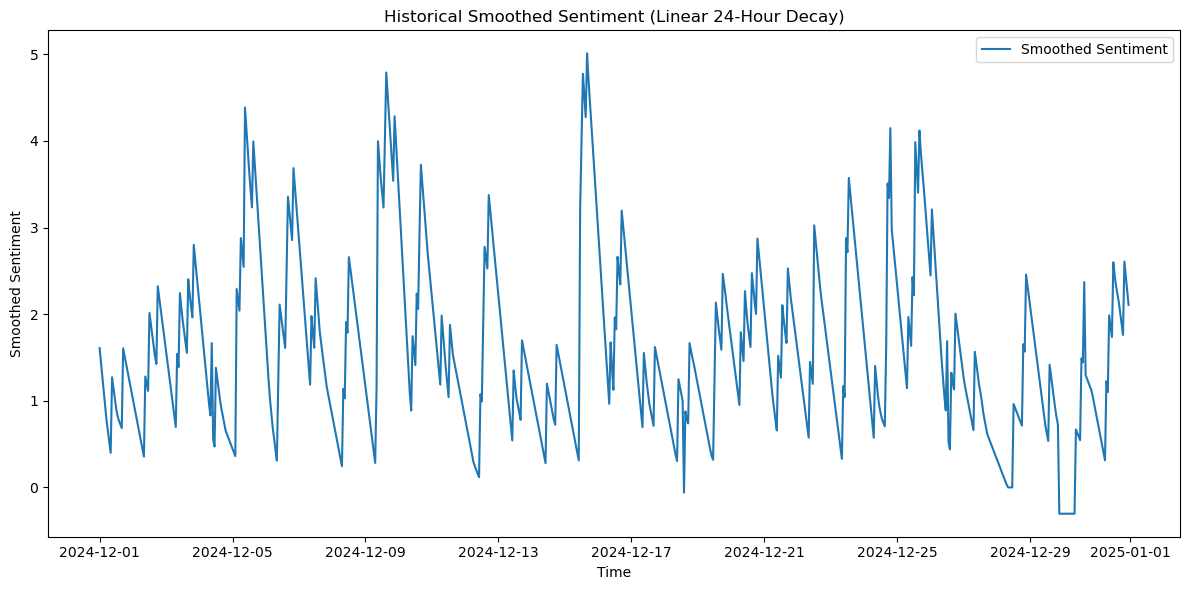

In [26]:


# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

                           smoothed_sentiment  smoothed_sentiment_weibull
2024-01-01 06:00:00+00:00            0.000000                    0.000000
2024-01-01 07:00:00+00:00            0.998623                    0.012845
2024-01-01 08:00:00+00:00            0.956956                    0.389727
2024-01-01 09:00:00+00:00            0.915289                    0.704364
2024-01-01 10:00:00+00:00            0.873623                    0.912876


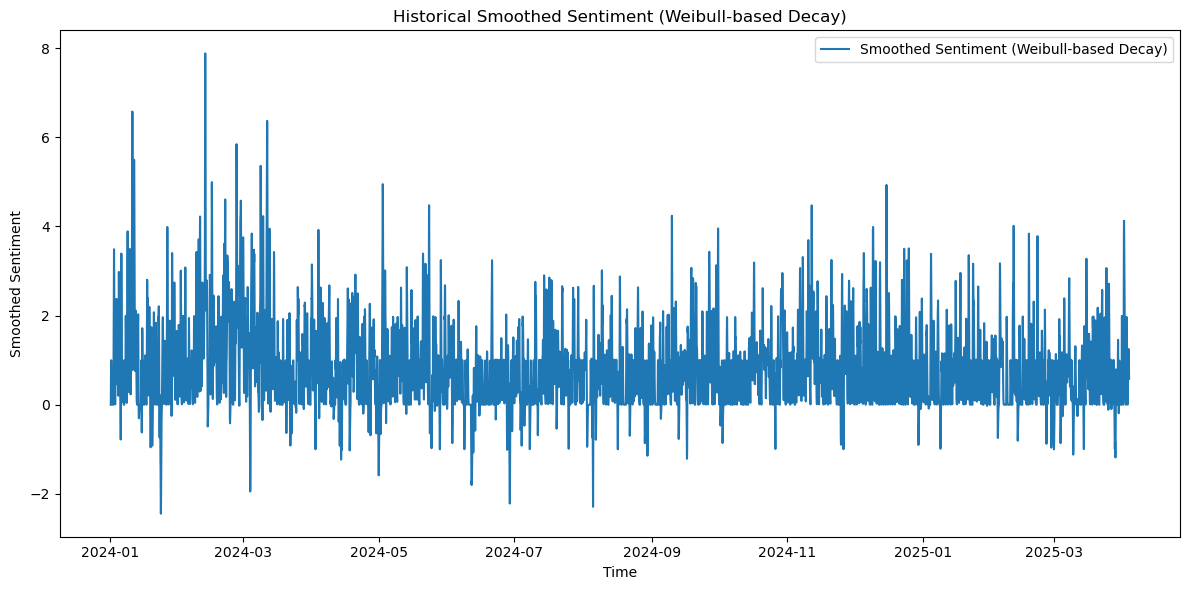

In [27]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

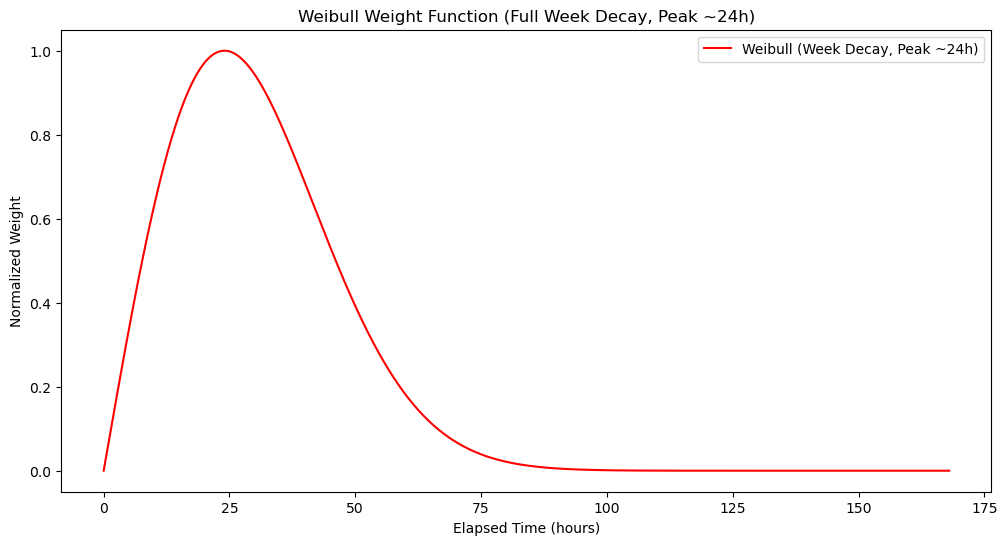

                           smoothed_sentiment  smoothed_sentiment_weibull  \
2024-01-01 06:00:00+00:00            0.000000                    0.000000   
2024-01-01 07:00:00+00:00            0.998623                    0.012845   
2024-01-01 08:00:00+00:00            0.956956                    0.389727   
2024-01-01 09:00:00+00:00            0.915289                    0.704364   
2024-01-01 10:00:00+00:00            0.873623                    0.912876   

                           smoothed_sentiment_weibull_week  
2024-01-01 06:00:00+00:00                         0.000000  
2024-01-01 07:00:00+00:00                         0.002271  
2024-01-01 08:00:00+00:00                         0.070902  
2024-01-01 09:00:00+00:00                         0.139164  
2024-01-01 10:00:00+00:00                         0.206704  


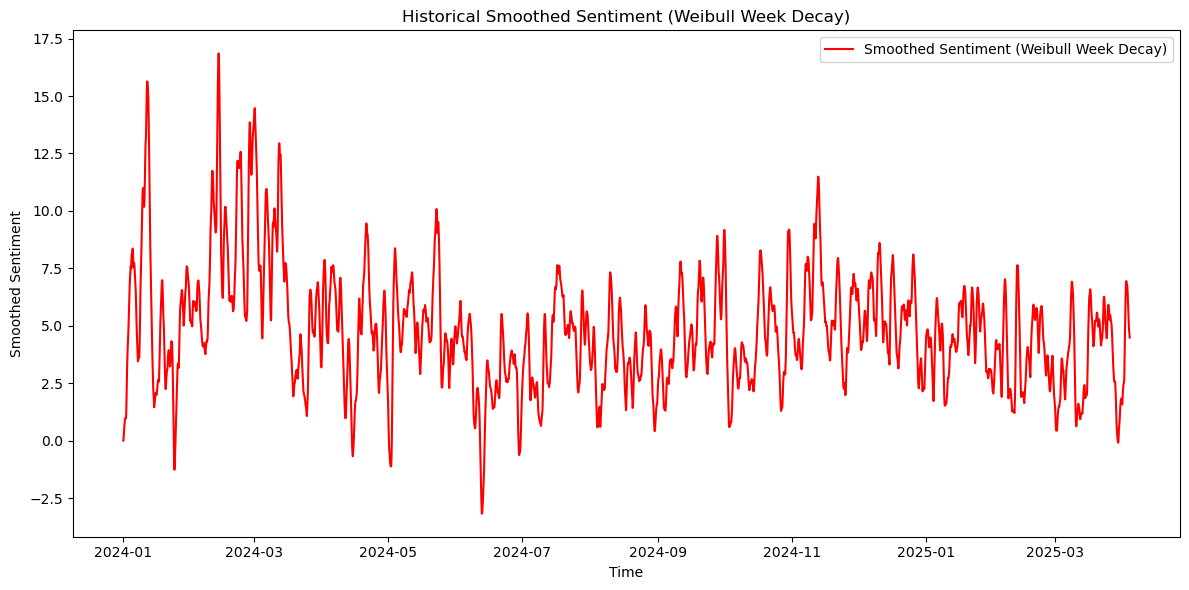

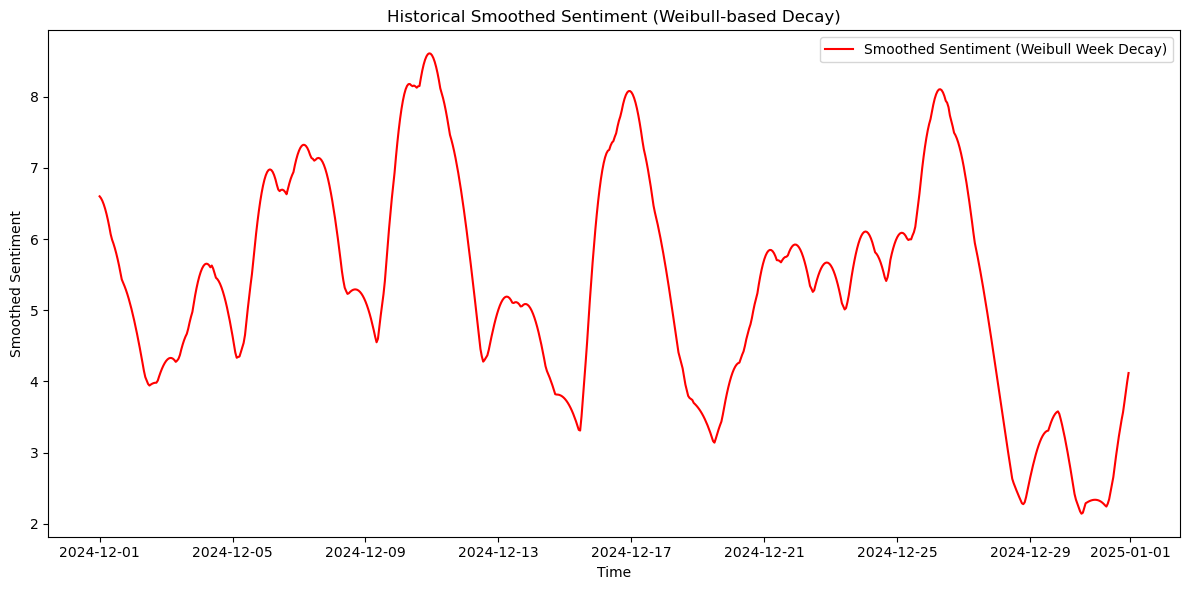

In [28]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np

# --- Alternative Weibull Parameters for a Full Week Decay ---
# We want the mode (peak) to be ~24 hours. For a Weibull with shape k,
# the mode is given by: mode = lam * ((k-1)/k)^(1/k)
# For k = 2.0, set lam such that lam/sqrt(2) = 24 => lam = 24 * sqrt(2)
k_week = 2.0
lam_week = 24 * np.sqrt(2)   # Approximately 33.94 hours
x_mode_week = lam_week * ((k_week - 1) / k_week) ** (1 / k_week)
max_weight_week = weibull_min.pdf(x_mode_week, k_week, scale=lam_week)

def weight_function_week(x):
    """
    Compute the weight for an elapsed time x (in hours) using a Weibull PDF 
    normalized so that the maximum weight is 1.
    
    This function is designed so that the impact of a post increases to a peak 
    around 24 hours and then decays over the course of one week (168 hours).
    """
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k_week, scale=lam_week) / max_weight_week

# --- For Comparison: Plot the Weight Function ---
x_vals = np.linspace(0, 168, 500)  # from 0 to 168 hours
y_vals = [weight_function_week(x) for x in x_vals]

plt.figure(figsize=(12,6))
plt.plot(x_vals, y_vals, label='Weibull (Week Decay, Peak ~24h)', color='red')
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Normalized Weight')
plt.title('Weibull Weight Function (Full Week Decay, Peak ~24h)')
plt.legend()
plt.show()

# --- Alternative Smoothed Sentiment Function Using the New Weight Function ---
def compute_smoothed_sentiment_weibull_week(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last week (168 hours) using the alternative Weibull function.
    """
    # Consider news events in the last 168 hours (1 week)
    window_start = t - pd.Timedelta(hours=168)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Calculate the elapsed time in hours since each post
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Apply the alternative Weibull weight function
    weights = time_diffs.apply(weight_function_week)
    # Sum the weighted sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# --- Assuming you have start_time, end_time, and df defined ---
# For example, if:
# start_time = df['created_at'].min().floor('H')
# end_time = df['created_at'].max().ceil('H')
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

# Compute the smoothed sentiment using the alternative function
smoothed_sentiments_week = [compute_smoothed_sentiment_weibull_week(t) for t in hourly_index]

# Save results in a DataFrame for further analysis/plotting
df_sentiment['smoothed_sentiment_weibull_week'] = smoothed_sentiments_week
print(df_sentiment.head())

plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull Week Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
df_sentiment

,smoothed_sentiment,smoothed_sentiment_weibull,smoothed_sentiment_weibull_week
2024-01-01 06:00:00+00:00,0.000000,0.000000,0.000000
2024-01-01 07:00:00+00:00,0.998623,0.012845,0.002271
2024-01-01 08:00:00+00:00,0.956956,0.389727,0.070902
2024-01-01 09:00:00+00:00,0.915289,0.704364,0.139164
2024-01-01 10:00:00+00:00,0.873623,0.912876,0.206704
...,...,...,...
2025-04-03 18:00:00+00:00,1.423345,1.231380,4.696564
2025-04-03 19:00:00+00:00,1.340012,1.129432,4.648396
2025-04-03 20:00:00+00:00,1.256678,0.965968,4.596983
2025-04-03 21:00:00+00:00,1.173345,0.771804,4.542238


In [ ]:
# tele_messages_with_sentiment_path = os.path.join(folder_path, 'tele_sentiment_04Apr.csv')
# df_sentiment.to_csv(tele_messages_with_sentiment_path)

In [ ]:
df = tele_messages.copy()
df.drop(columns=['smoothed_sentiment_weibull'], inplace=True)

In [ ]:
df

,date,text,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,year,week,day,sentiment
0,2024-01-01 06:00:00+00:00,"**January 1, 2024 MARKET ANALYSIS:** Market C...",0.0,0.0,0.0,1.0,0.0,0.0,2024,1,0,positive
1,2024-01-01 11:00:00+00:00,"$BTC VIP Analysis January 01, 2024 -----------...",1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive
2,2024-01-01 15:00:00+00:00,**$BTC**** DOMINANCE UPDATE VIP --------------...,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive
3,2024-01-01 20:00:00+00:00,**$SEI**** update !!! +67.44% profit in btc pa...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive
4,2024-01-01 20:00:00+00:00,$GMT **update !!! +19.02% profit in btc pairin...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
3391,2025-03-28 02:00:00+00:00,**UPDATE VIP** **------------------- ******** ...,1.0,0.0,0.0,0.0,0.0,0.0,2025,13,4,negative
3392,2025-03-28 05:00:00+00:00,**#BTC****/USDT UPDATE:** Bitcoin has been tra...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,negative
3393,2025-03-28 06:00:00+00:00,The U.S. government transferred approximately ...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,neutral
3394,2025-03-28 07:00:00+00:00,"**March 28, 2025 MARKET ANALYSIS:** Market Ca...",0.0,0.0,0.0,1.0,0.0,0.0,2025,13,4,neutral


In [ ]:
df = df.rename(columns={'date': 'datetime'})
df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('H')
df = df.set_index('datetime')
df = df.join(df_sentiment)


C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\2330747170.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('H')


In [ ]:
df

,text,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,year,week,day,sentiment,smoothed_sentiment,smoothed_sentiment_weibull,smoothed_sentiment_weibull_week
2024-01-01 06:00:00+00:00,"**January 1, 2024 MARKET ANALYSIS:** Market C...",0.0,0.0,0.0,1.0,0.0,0.0,2024,1,0,positive,1.000000,0.000000,0.000000
2024-01-01 11:00:00+00:00,"$BTC VIP Analysis January 01, 2024 -----------...",1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,1.791667,0.970259,0.336110
2024-01-01 15:00:00+00:00,**$BTC**** DOMINANCE UPDATE VIP --------------...,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,2.458333,1.365300,0.847288
2024-01-01 20:00:00+00:00,**$SEI**** update !!! +67.44% profit in btc pa...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,3.833333,1.362393,1.723687
2024-01-01 20:00:00+00:00,$GMT **update !!! +19.02% profit in btc pairin...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,3.833333,1.362393,1.723687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28 02:00:00+00:00,**UPDATE VIP** **------------------- ******** ...,1.0,0.0,0.0,0.0,0.0,0.0,2025,13,4,negative,1.166667,1.375576,6.453655
2025-03-28 05:00:00+00:00,**#BTC****/USDT UPDATE:** Bitcoin has been tra...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,negative,-0.208333,-0.430358,6.208779
2025-03-28 06:00:00+00:00,The U.S. government transferred approximately ...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,neutral,-0.291667,-1.075539,6.043296
2025-03-28 07:00:00+00:00,"**March 28, 2025 MARKET ANALYSIS:** Market Ca...",0.0,0.0,0.0,1.0,0.0,0.0,2025,13,4,neutral,-1.375000,-1.488842,5.870617


In [ ]:
tele_messages_with_sentiment_path = os.path.join(folder_path, 'tele_messages_processed_hourly_2803_with_weekWeibull.csv')
df.to_csv(tele_messages_with_sentiment_path)